In [84]:
import os
import numpy as np
import nibabel as nib
from tqdm import tqdm
from torch.utils.data import Dataset
import random
import torch
import torchio as tio
from torchio.transforms import HistogramStandardization
import matplotlib.pyplot as plt
from dataset_tio import calculate_overlap, sim_data, MRBrainS18_data, HCP_data, mixed_data, MRBrainS18Image, HCPImage, SimImage, OASISImage
from transform import Normalize, RandomIntensity, Intensity, RandomGamma
from glob import glob
# from dataset_tio_2 import mixed_data
import torchvision
from models.generator_ESRGAN import GeneratorRRDB as generator_ESRGAN
from models.generator_RRDB import GeneratorRRDB as generator_RRDB
from models.generator_DeepUResnet import DeepUResnet as generator_DeepUResnet
from models.discriminator import Discriminator
from models.feature_extractor import FeatureExtractor

from trainer_org import LitTrainer as LitTrainer_org
from trainer_gan import LitTrainer as LitTrainer_gan
import pytorch_lightning as pl

from torchvision.utils import save_image
from torchsummary import summary
import time
from utils import save_subject, save_subject_all, get_mean_and_std
from skimage.metrics import structural_similarity as SSIM
from skimage.metrics import normalized_root_mse as NRMSE
from skimage import exposure

from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset
import pprint
print(os.getcwd())
import cv2


/mnt/beta/djboonstoppel/Code


In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
std = 0.3548
device = torch.device("cuda:0" if (torch.cuda.is_available()) else "cpu")

In [4]:
generator = generator_RRDB(channels=1, filters=64, num_res_blocks=1)
# generator_marcel = DeepUResnet(nrfilters=64)
# generator_old = GeneratorRRDB_old(channels=1, filters=64, num_res_blocks=1)
discriminator = Discriminator(input_shape=(1, 64, 64))
feature_extractor = FeatureExtractor()

In [5]:
generator.to(device)

GeneratorRRDB(
  (conv1): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (1): ReLU()
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (3): ReLU()
  )
  (res_blocks): Sequential(
    (0): ResidualInResidualDenseBlock(
      (RDB): ResidualDenseBlock(
        (b1): Sequential(
          (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
          (1): ReLU()
        )
        (b2): Sequential(
          (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
          (1): ReLU()
        )
        (b3): Sequential(
          (0): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
          (1): ReLU()
        )
        (b4): Sequential(
          (0): Conv2d(192, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
          (1): ReLU()
        )
        (b5): Sequential(
          (0): Conv2d(256, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
          (1): ReLU()
   

In [6]:
exp_name = 'generator_esrgan'
epoch = 9
ckpt_fname = '{}-checkpoint-epoch={}.ckpt'.format(exp_name, epoch)
ckpt_path = os.path.join('log', exp_name, ckpt_fname)

In [13]:
print(os.path.split(os.path.split(ckpt_path)[0])[1])

generator_esrgan


In [15]:
summary(generator_old, input_size=(1, 64, 64), batch_size=16, device='cpu')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [16, 64, 64, 64]             640
              ReLU-2           [16, 64, 64, 64]               0
            Conv2d-3           [16, 64, 64, 64]          36,928
              ReLU-4           [16, 64, 64, 64]               0
            Conv2d-5           [16, 64, 64, 64]          36,928
              ReLU-6           [16, 64, 64, 64]               0
            Conv2d-7           [16, 64, 64, 64]          36,928
              ReLU-8           [16, 64, 64, 64]               0
            Conv2d-9           [16, 64, 64, 64]          73,792
             ReLU-10           [16, 64, 64, 64]               0
           Conv2d-11           [16, 64, 64, 64]         110,656
             ReLU-12           [16, 64, 64, 64]               0
           Conv2d-13           [16, 64, 64, 64]         147,520
             ReLU-14           [16, 64,

In [6]:
mixed_list = mixed_data('training', patients_frac=0.1)

Loading simulated training set...
Loading HCP training set...


In [10]:
numpy_list = [mixed_list[i]['LR'][tio.DATA].numpy() for i in range(len(mixed_list))]

(1, 320, 320, 179)


In [80]:
# nifty_list = glob("/mnt/beta/djboonstoppel/Code/data/**/*.nii.gz", recursive=True)
nifty_list = glob("/mnt/beta/djboonstoppel/Code/data/brain_simulated_t1w_mri/1mm_07mm/LR_img/*.nii.gz") + \
             glob("/mnt/beta/djboonstoppel/Code/data/brain_real_t1w_mri/HCP/LR/*.nii.gz") + \
             glob("/mnt/beta/djboonstoppel/Code/data/brain_real_t1w_mri/OASIS/LR/*.nii.gz") + \
             glob("/mnt/beta/djboonstoppel/Code/data/brain_real_t1w_mri/MRBrainS18/LR/*.nii.gz")

print(len(nifty_list))
# test = HistogramStandardization.train(nifty_list)

267


In [70]:
from pathlib import Path
landmarks_path = Path('landmarks.npy')
landmarks = HistogramStandardization.train(nifty_list)
print(landmarks)

 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                          | 200/267 [02:44<00:54,  1.23it/s]/mnt/beta/djboonstoppel/miniconda/lib/python3.9/site-packages/torchio/data/io.py:36: UserWarning: Error loading image with SimpleITK:
Exception thrown in SimpleITK ImageFileReader_Execute: /tmp/SimpleITK-build/ITK/Modules/IO/NIFTI/src/itkNiftiImageIO.cxx:1980:
ITK ERROR: ITK only supports orthonormal direction cosines.  No orthonormal definition found!

Trying NiBabel...
  warnings.warn(message)
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 267/267 [03:32<00:00,  1.25it/s]

[-4.44089210e-16  7.77868414e-02  7.79335440e-02  7.79335440e-02
  7.79335440e-02  7.79335440e-02  7.79335440e-02  7.79335440e-02
  7.87907131e-02  1.48613629e+00  9.10327424e+00  7.17148064e+01
  1.00000000e+02]


In [71]:
np.save(landmarks_path, landmarks)

In [24]:
landmarks_loaded = np.load('landmarks.npy')
landmarks = {
    'LR': landmarks_loaded,
    'HR': landmarks_loaded,
}
print(landmarks['HR'])
transform = tio.HistogramStandardization(landmarks)

[-4.44089210e-16  7.77868414e-02  7.79335440e-02  7.79335440e-02
  7.79335440e-02  7.79335440e-02  7.79335440e-02  7.79335440e-02
  7.87907131e-02  1.48613629e+00  9.10327424e+00  7.17148064e+01
  1.00000000e+02]


In [215]:
def hist(subject, bins=20, minmax = (0.05,1)):
    x = np.linspace(minmax[0], minmax[1], bins)
    hist = torch.histc(subject['LR'][tio.DATA], bins = bins, min =minmax[0], max=minmax[1])
    plt.figure()
    plt.plot(x, hist)

background: 0.0
min: 0.0
max: 4095.0


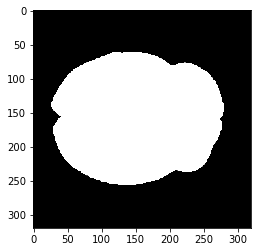

In [48]:
img_sim = SimImage(number=120010, middle_slices=None, every_other=1, data_resolution='1mm_07mm')
img_sim_norm = SimImage(number=120010, middle_slices=None, every_other=1, data_resolution='1mm_07mm', hist_eq=True)
subject = img_sim.subject()
# hist(subject)
print('background: {}\nmin: {}\nmax: {}'.format(
    subject['LR'][tio.DATA][0,0,0,0],
    torch.min(subject['LR'][tio.DATA]),
    torch.max(subject['LR'][tio.DATA])))

plt.figure()
plt.imshow(subject['LR'][tio.DATA][0,:,:,100], cmap='gray', vmin=0, vmax=1)

background: 0.0
min: -376.0
max: 3719.0


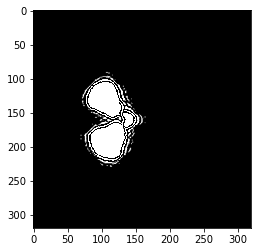

In [49]:
img_real = HCPImage(number=120010, middle_slices=None, every_other=1)
img_real_norm = HCPImage(number=120010, middle_slices=None, every_other=1, hist_eq=True)
subject = img_real.subject()
# hist(subject)
print('background: {}\nmin: {}\nmax: {}'.format(
    subject['LR'][tio.DATA][0,0,0,0],
    torch.min(subject['LR'][tio.DATA]),
    torch.max(subject['LR'][tio.DATA])))

plt.figure()
plt.imshow(subject['LR'][tio.DATA][0,:,:,5], cmap='gray', vmin=0, vmax=1)

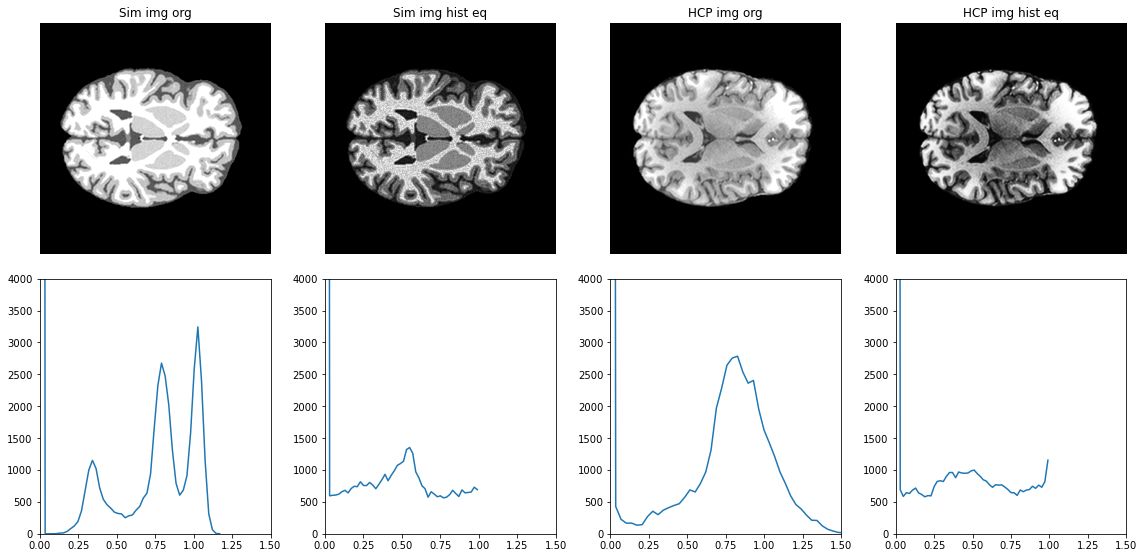

In [32]:
fig, [[ax1, ax2, ax3, ax4],[ax5, ax6, ax7, ax8]] = plt.subplots(2,4, figsize=[16,8])
fig.set_facecolor('white')
images = [img_sim, img_sim_norm, img_real, img_real_norm]

for aa in (ax1, ax2, ax3, ax4):
    aa.set_axis_off()

ax1.imshow(img_sim.subject()['LR'][tio.DATA][0,:,:,100], cmap='gray', vmin=0, vmax=1)
ax1.set_title('Sim img org')
ax2.imshow(img_sim_norm.subject()['LR'][tio.DATA][0,:,:,100], cmap='gray', vmin=0, vmax=1)
ax2.set_title('Sim img hist eq')
ax3.imshow(img_real.subject()['LR'][tio.DATA][0,:,:,100], cmap='gray', vmin=0, vmax=1.2)
ax3.set_title('HCP img org')
ax4.imshow(img_real_norm.subject()['LR'][tio.DATA][0,:,:,100], cmap='gray', vmin=0, vmax=1)
ax4.set_title('HCP img hist eq')

for i, ax in enumerate((ax5, ax6, ax7, ax8)):
    histogram = exposure.histogram(images[i].subject()['LR'][tio.DATA][0,:,:,100].numpy(), nbins=50)
    # count = np.delete(histogram[0], np.argmax(histogram[0]))
    # bins = np.delete(histogram[1], np.argmax(histogram[0]))
    count = histogram[0]
    bins = histogram[1]
    ax.plot(bins, count)
    ax.set_xlim([0, 1.5])
    ax.set_ylim([0,4000])

plt.tight_layout()
plt.show()

(400, 600, 3)
<class 'numpy.uint8'>


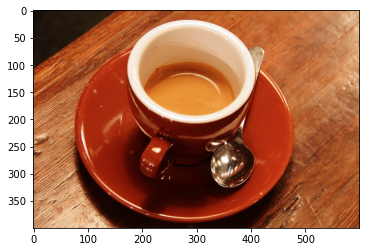

In [22]:
from skimage import data
test = data.coffee()
plt.imshow(test)
print(test.shape)
print(type(test[0,0,0]))

In [50]:
image = img_sim.subject()['LR'][tio.DATA][[0],:,:,:].numpy()
print(image.shape)
reference = img_real.subject()['LR'][tio.DATA][[0],:,:,:].numpy()#.unsqueeze(0).unsqueeze(3).numpy()
print(reference.shape)

(1, 320, 320, 179)
(1, 320, 320, 179)


In [114]:
print(image.shape)
print(type(image[0,0,0]))
print(np.max(image))
print(reference.shape)
print(type(reference[0,0,0]))
print(np.max(reference))

(1, 320, 320, 20)
<class 'numpy.ndarray'>
1.2264150943396226
(1, 320, 320, 20)
<class 'numpy.ndarray'>
1.6829268292682926


In [25]:
fcm_norm = FCMNormalize(tissue_type=TissueType.WM)

test = fcm_norm(img_sim.subject()['LR'][tio.DATA][[0],:,:,:].numpy(), img_sim.subject()['MSK'][tio.DATA][[0],:,:,:].numpy())

(1, 320, 320, 179)
1.2611641515244842 1.2491869427526197


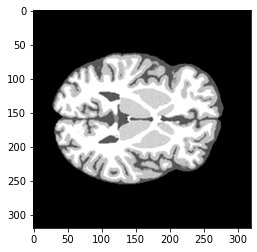

In [28]:
print(test.shape)
plt.imshow(test[0,:,:,100], cmap='gray', vmin=0, vmax=1)
print(np.max(image), np.max(test))

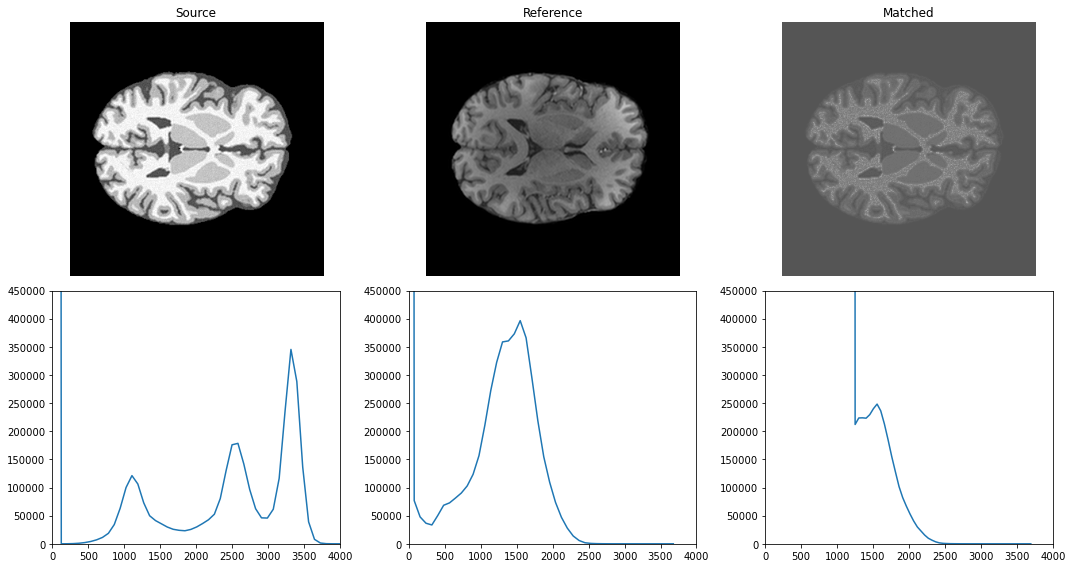

In [52]:
matched = exposure.match_histograms(image, reference, channel_axis=0)
# p2, p98 = np.percentile(matched, (1, 99))
# matched = exposure.rescale_intensity(matched, in_range=(p2, 1.4), out_range=(0.2,1.4))
images = [image, reference, matched]
fig, [[ax1, ax2, ax3],[ax4, ax5, ax6]] = plt.subplots(nrows=2, ncols=3, figsize=(15, 8))
fig.set_facecolor('white')

for aa in (ax1, ax2, ax3):
    aa.set_axis_off()

ax1.imshow(image[0,:,:,100], cmap='gray', vmin=0, vmax=3500)
ax1.set_title('Source')
ax2.imshow(reference[0,:,:,100], cmap='gray', vmin=0, vmax=3500)
ax2.set_title('Reference')
ax3.imshow(matched[0,:,:,100], cmap='gray', vmin=0, vmax=3500)
ax3.set_title('Matched')

for i, ax in enumerate((ax4, ax5, ax6)):
    histogram = exposure.histogram(images[i].squeeze(), nbins=50)
    # count = np.delete(histogram[0], np.argmax(histogram[0]))
    # bins = np.delete(histogram[1], np.argmax(histogram[0]))
    count = histogram[0]
    bins = histogram[1]
    ax.plot(bins, count)
    ax.set_xlim([0, 4000])
    ax.set_ylim([0,450000])

plt.tight_layout()
plt.show()

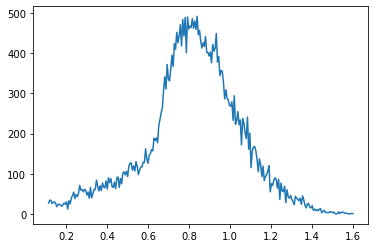

In [71]:
histogram = exposure.histogram(matched.squeeze())
# print(histogram)
# print(np.max(histogram[0]))
# print(np.argmax(histogram[0]))
# print(histogram[1][np.argmax(histogram[0])])
count = np.delete(histogram[0], np.argmax(histogram[0]))
bins = np.delete(histogram[1], np.argmax(histogram[0]))
plt.plot(bins, count)


In [68]:
print(test)
torch.save(test, 'landmarks.npy')

[[[ 21  13   8]
  [ 21  13   9]
  [ 20  11   8]
  ...
  [228 182 138]
  [231 185 142]
  [228 184 140]]

 [[ 21  13   7]
  [ 21  13   9]
  [ 20  14   7]
  ...
  [228 182 136]
  [231 185 139]
  [229 183 137]]

 [[ 21  14   7]
  [ 23  13  10]
  [ 20  14   9]
  ...
  [228 182 136]
  [228 184 137]
  [229 185 138]]

 ...

 [[189 124  77]
  [214 155 109]
  [197 141 100]
  ...
  [165  86  37]
  [161  82  41]
  [143  67  29]]

 [[207 148 102]
  [201 142  99]
  [196 140  97]
  ...
  [154  74  37]
  [147  66  33]
  [145  65  31]]

 [[197 141 100]
  [195 137  99]
  [193 138  98]
  ...
  [158  73  38]
  [144  64  30]
  [143  60  29]]]


In [51]:
test = np.load('landmarks.npy')
print(test)

In [ ]:
img_real = MRBrainS18Image(number=1, middle_slices=None, every_other=1)
print(img_real.subject()['LR'].data.shape)
print(img_real.info()['LR'])
real_subject = [img_real.subject()]
real_set = tio.SubjectsDataset(
    real_subject, transform=Normalize(std=std))

real_set[0].plot()

In [95]:
transforms = tio.Compose([
    RandomGamma(),

    RandomIntensity(),

    # Normalize(std=std),
    # tio.RandomNoise(p=0.5),
])

-0.114084736 2.9097002
0.021865977 3.3962884


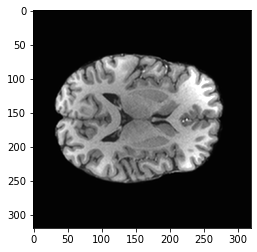

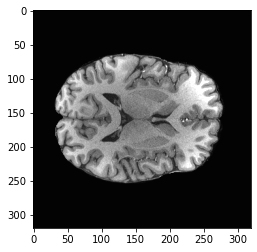

In [102]:
img_real = HCPImage(number=120010, middle_slices=None, every_other=1)
# print(img_real.subject()['LR'].data.shape)
# print(img_real.info()['LR'])
real_subject = [img_real.subject()]*10
real_set = tio.SubjectsDataset(
    real_subject, transform=transforms)

test = real_set[0]
# real_set[0].plot()
print(np.min(test['LR'][tio.DATA].numpy()), np.max(test['LR'][tio.DATA].numpy()), )
print(np.min(test['HR'][tio.DATA].numpy()), np.max(test['HR'][tio.DATA].numpy()), )
plt.figure()
plt.imshow(test['LR'][tio.DATA].numpy()[0,:,:,100], cmap='gray', vmin=0, vmax=1.5)
plt.figure()
plt.imshow(test['HR'][tio.DATA].numpy()[0,:,:,100], cmap='gray', vmin=0, vmax=1.5)

torch.Size([1, 176, 208, 176])
{'header': <nibabel.nifti1.Nifti1Header object at 0x7fcb27096640>, 'scaling': 1267.0}


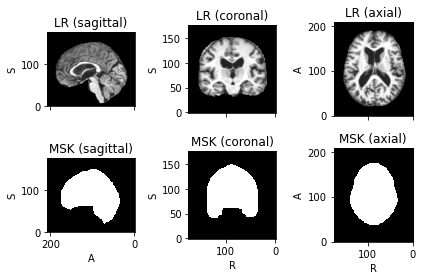

In [74]:
img_real = OASISImage(number=1, middle_slices=None, every_other=1)
print(img_real.subject()['LR'].data.shape)
print(img_real.info()['LR'])
real_subject = [img_real.subject()]
real_set = tio.SubjectsDataset(
    real_subject, transform=Normalize(std=std))

real_set[0].plot()

torch.Size([1, 320, 320, 179])
{'header': <nibabel.nifti1.Nifti1Header object at 0x7fcadc100640>, 'scaling': 3247.0}
0.000603497 1.2714083
0.000603497 1.2597914


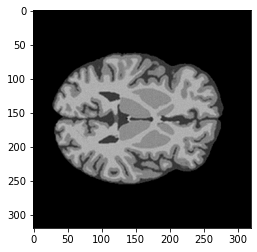

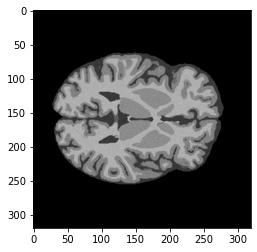

In [109]:
img_real = SimImage(number=120010, middle_slices=None, every_other=1, data_resolution='1mm_07mm')
print(img_real.subject()['LR'].data.shape)
print(img_real.info()['LR'])
real_subject = [img_real.subject()]
real_set = tio.SubjectsDataset(
    real_subject, transform=transforms)

test = real_set[0]
# real_set[0].plot()
print(np.min(test['LR'][tio.DATA].numpy()), np.max(test['LR'][tio.DATA].numpy()), )
print(np.min(test['HR'][tio.DATA].numpy()), np.max(test['HR'][tio.DATA].numpy()), )
plt.figure()
plt.imshow(test['LR'][tio.DATA].numpy()[0,:,:,100], cmap='gray', vmin=0, vmax=1.5)
plt.figure()
plt.imshow(test['HR'][tio.DATA].numpy()[0,:,:,100], cmap='gray', vmin=0, vmax=1.5)

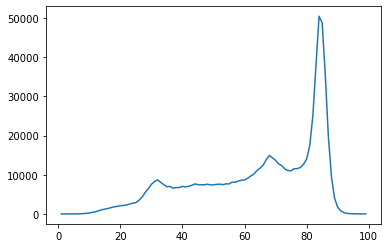

In [185]:
def hist(subject, bins=100):
    x = range(bins)
    hist = torch.histc(subject['LR'][tio.DATA], bins = bins)
    plt.plot(x[1:], hist[1:])
# array = real_set[0]['LR'][tio.DATA]
# # print(array)
# bins=100
# hist = torch.histc(array, bins=bins)
# x=range(bins)
# plt.plot(x[1:], hist[1:])
hist(real_set[0])

In [177]:
from glob import glob
root_dir = 'data'

path = root_dir + "/brain_real_t1w_mri/HCP/HR/"
fnames = glob(path + "*.nii.gz")
ids = sorted(list(map(int, [(fnames[i][-29:-23]) for i in range(len(fnames))])))
print(ids)

[120010, 120111, 120212, 120414, 120515, 120717, 121315, 121416, 121618, 121719, 121820, 121921, 122317, 122418, 122620, 122822, 123117, 123420, 123521, 123723, 123824, 123925, 124220, 124422, 124624, 124826, 125222, 125424, 125525, 126325, 126426, 126628, 126931, 127226, 127327, 127630, 127731, 127832, 127933, 128026, 128127, 128329, 128632, 128935, 129028, 129129, 129331, 129432, 129533, 129634]


In [31]:
hcp_data_list = hcp_data(middle_slices=None)
print(hcp_data_list)

[120010, 120111, 120212, 120414, 120515, 120717, 121315, 121416, 121618, 121719, 121820, 121921, 122317, 122418, 122620, 122822, 123117, 123420, 123521, 123723, 123824, 123925, 124220, 124422, 124624, 124826, 125222, 125424, 125525, 126325, 126426, 126628, 126931, 127226, 127327, 127630, 127731, 127832, 127933, 128026, 128127, 128329, 128632, 128935, 129028, 129129, 129331, 129432, 129533, 129634]
Loading hcp dataset...
[Subject(Keys: ('LR', 'HR'); images: 2), Subject(Keys: ('LR', 'HR'); images: 2), Subject(Keys: ('LR', 'HR'); images: 2), Subject(Keys: ('LR', 'HR'); images: 2), Subject(Keys: ('LR', 'HR'); images: 2), Subject(Keys: ('LR', 'HR'); images: 2), Subject(Keys: ('LR', 'HR'); images: 2), Subject(Keys: ('LR', 'HR'); images: 2), Subject(Keys: ('LR', 'HR'); images: 2), Subject(Keys: ('LR', 'HR'); images: 2), Subject(Keys: ('LR', 'HR'); images: 2), Subject(Keys: ('LR', 'HR'); images: 2), Subject(Keys: ('LR', 'HR'); images: 2), Subject(Keys: ('LR', 'HR'); images: 2), Subject(Keys: (

In [37]:
transform = None

set = tio.SubjectsDataset(hcp_data_list, transform=transform)
sampler = tio.data.GridSampler(patch_size=(64,64, 1),
                               patch_overlap=(32,32,0),
                               padding_mode=None,
                               )
queue = tio.Queue(
    subjects_dataset=set,
    max_length=15000 * 10,
    samples_per_volume=15000,
    sampler=sampler,
    num_workers=4,
    shuffle_subjects=True,
    shuffle_patches=True,
)
loader = torch.utils.data.DataLoader(
    queue,
    batch_size=64,
    num_workers=0,
)
mean, std = get_mean_and_std(loader)

In [38]:
print(mean, std)

tensor([0.2271], dtype=torch.float64) tensor([0.3869], dtype=torch.float64)


torch.Size([1, 320, 320, 159])


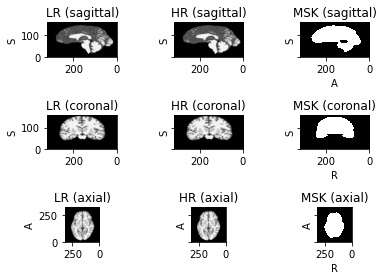

In [49]:
# img_sim = SimImagePair(number=100206, middle_slices=None, every_other=1, data_resolution='1mm_07mm')
# print(img_sim.subject()['LR'].data.shape)
# sim_subject = [img_sim.subject()]
# sim_set = tio.SubjectsDataset(
#     sim_subject, transform=Normalize(std=std))
#
# sim_set[0].plot()

In [17]:
test_subjects = MRBrainS18_data(root_dir='data',
                          middle_slices=None,
                          every_other=1)
# test_subjects = [test_subjects[0]]

test_set_real = tio.SubjectsDataset(
    test_subjects, transform=Normalize(std=std))

Loading real dataset...


In [26]:
test_subjects = sim_data(dataset = 'training',
                         patients_frac=.1,
                         data_resolution='2mm_1mm',
                         middle_slices=None,
                         every_other=1)
# test_subjects = [test_subjects[0]]

test_set_sim = tio.SubjectsDataset(
    test_subjects, transform=Normalize(std=std))


Loading simulated training set...


In [9]:
# source = 'sim'
#
# if source == 'sim':
#     img = sim_set
# elif source == 'real':
#     img = real_set

In [10]:
# ### baseline
# config1 = {
#     'optimizer': 'adam',
#     'b1': 0.9,
#     'b2': 0.5,
#     'batch_size': 16,
#     'num_filters': 64,
#     'learning_rate_G': 1e-4,
#     'learning_rate_D': 1e-4,
#     'patch_size': 64,
#     'alpha_content': 0,
#     'alpha_adversarial': 0.1,
#     'ragan': False,
#     'gan_mode': 'vanilla',
#     'edge_loss': 2,
#     'netD_freq': 1,
#     'data_resolution': '2mm_1mm',
#     'patients_frac': 0.5,
#     'patch_overlap': 0.5,
# }
#
# root = '/mnt/beta/djboonstoppel/Code'
# exp_name = 'baseline_gan'
# version = 0
# epoch = 55
# ckpt_fname = '{}-checkpoint-epoch={}.ckpt'.format(exp_name, epoch)
# path1 = os.path.join(root, 'log', exp_name, 'version_{}'.format(version), ckpt_fname)

In [11]:
# config1= {
#     'optimizer': 'adam',
#     'b1': 0.9,
#     'b2': 0.5,
#     'batch_size': 16,
#     'num_filters': 64,
#     'learning_rate_G': 1e-4,
#     'learning_rate_D': 1e-5,
#     'patch_size': 64,
#     'alpha_content': 1,
#     'alpha_adversarial': 0.1,
#     'ragan': True,
#     'gan_mode': 'wgan',
#     'edge_loss': 2,
#     'netD_freq': 1,
#     'data_resolution': '2mm_1mm',
#     'patients_frac': 0.5,
#     'patch_overlap': 0.5,
# }
#
# root = '/mnt/beta/djboonstoppel/Code'
# exp_name = 'disc_lr'
# name = '1e-05'
# epoch = 4
# ckpt_fname = 'checkpoint_{}-epoch={}.ckpt'.format(name, epoch)
# path1 = os.path.join(root, 'ray_results', exp_name, 'checkpoints', ckpt_fname)


In [3]:
config1 = {
    'optimizer': 'adam',
    'b1': 0.9,
    'b2': 0.5,
    'batch_size': 16,
    'num_filters': 64,
    'learning_rate_G': 5e-5,
    'learning_rate_D': 5e-5,
    'patch_size': 64,
    'alpha_content': 1,
    'alpha_adversarial': 0.1,
    'ragan': False,
    'gan_mode': 'vanilla',
    'edge_loss': 2,
    'netD_freq': 1,
    'data_resolution': '2mm_1mm',
    'patients_frac': 0.5,
    'patch_overlap': 0.5,
    'num_patients': 30,
    'num_real': 1,
}

In [4]:
class AttrDict(dict):
    def __init__(self, *args, **kwargs):
        super(AttrDict, self).__init__(*args, **kwargs)
        self.__dict__ = self

In [8]:
config1 = AttrDict(config1)

In [9]:
config1.optimizer

'adam'

In [8]:
# root = '/mnt/beta/djboonstoppel/Code'
# exp_name = 'mixed_data'
# version = 2
# epoch = 0
# ckpt_fname = '{}-checkpoint-epoch={}.ckpt'.format(exp_name, epoch)
# path1 = os.path.join(root, 'log', exp_name, 'version_{}'.format(version), ckpt_fname)

In [9]:
# epoch = 1
# ckpt_fname = '{}-checkpoint-epoch={}.ckpt'.format(exp_name, epoch)
# path2 = os.path.join(root, 'log', exp_name, 'version_{}'.format(version), ckpt_fname)

In [9]:
root = '/mnt/beta/djboonstoppel/Code'
exp_name = 'mixed_data_sweep_2'
name = 0
epoch = 14
ckpt_fname = 'checkpoint_{}-epoch={}.ckpt'.format(name, epoch)
path1 = os.path.join(root, 'ray_results', exp_name, 'checkpoints', ckpt_fname)

In [10]:
name = 1
epoch = 14
ckpt_fname = 'checkpoint_{}-epoch={}.ckpt'.format(name, epoch)
path2 = os.path.join(root, 'ray_results', exp_name, 'checkpoints', ckpt_fname)

In [11]:
name = 2
epoch = 14
ckpt_fname = 'checkpoint_{}-epoch={}.ckpt'.format(name, epoch)
path3 = os.path.join(root, 'ray_results', exp_name, 'checkpoints', ckpt_fname)

In [12]:
name = 3
epoch = 14
ckpt_fname = 'checkpoint_{}-epoch={}.ckpt'.format(name, epoch)
path4 = os.path.join(root, 'ray_results', exp_name, 'checkpoints', ckpt_fname)

In [13]:
name = 4
epoch = 14
ckpt_fname = 'checkpoint_{}-epoch={}.ckpt'.format(name, epoch)
path5 = os.path.join(root, 'ray_results', exp_name, 'checkpoints', ckpt_fname)

In [14]:
name = 5
epoch = 14
ckpt_fname = 'checkpoint_{}-epoch={}.ckpt'.format(name, epoch)
path6 = os.path.join(root, 'ray_results', exp_name, 'checkpoints', ckpt_fname)

In [15]:
name = 6
epoch = 14
ckpt_fname = 'checkpoint_{}-epoch={}.ckpt'.format(name, epoch)
path7 = os.path.join(root, 'ray_results', exp_name, 'checkpoints', ckpt_fname)

In [16]:
# batch_size = 16
#
# patch_size = (64,64)
# ovl_perc = (.5,.5)
# overlap, nr_patches = calculate_overlap(img[0]['LR'], patch_size, ovl_perc)
#
# subject = img[0]
# grid_sampler = tio.inference.GridSampler(
#     subject,
#     patch_size=(*patch_size,1),
#     patch_overlap=overlap,
#     padding_mode=0,
# )
#
# patch_loader = torch.utils.data.DataLoader(
#     grid_sampler, batch_size=16)
#
# configs = [config_bep, config_content, config_gan]
# paths = [path_bep, path_content, path_gan]
# gan = [False, False, True]
#
# for i in range(len(paths)):
#     if gan[i]:
#         model = LitTrainer_gan.load_from_checkpoint(
#             netG=generator,
#             netF=feature_extractor,
#             netD=discriminator,
#             checkpoint_path=paths[i],
#             config=configs[i]
#         )
#     else:
#         model = LitTrainer_org.load_from_checkpoint(
#             netG=generator,
#             netF=feature_extractor,
#             checkpoint_path=paths[i],
#             config=configs[i]
#         )
#     batch_size = model.hparams.config['batch_size']
#
#     patch_size = (model.hparams.config['patch_size'],model.hparams.config['patch_size'])
#     ovl_perc = (model.hparams.config['patch_overlap'], model.hparams.config['patch_overlap'])
#     overlap, nr_patches = calculate_overlap(img[0]['LR'], patch_size, ovl_perc)
#
#     aggregator = tio.inference.GridAggregator(grid_sampler)#, overlap_mode='average')
#     with torch.no_grad():
#         for patches_batch in patch_loader:
#             imgs_lr, imgs_hr = patches_batch['LR'][tio.DATA].squeeze(4), patches_batch['HR'][tio.DATA].squeeze(4)
#             gen_hr = model(imgs_lr.to(device)).unsqueeze(4)
#             locations = patches_batch[tio.LOCATION]
#             aggregator.add_batch(gen_hr, locations)
#
#     foreground = aggregator.get_output_tensor()
#     generated = tio.ScalarImage(tensor=foreground)
#     subject.add_image(generated, 'SR'+str(i))
# subject.plot(figsize=(9, 8))
#

In [17]:
# if source == 'sim':
#     img_source = img_sim
# elif source == 'real':
#     img_source = img_real
#
# fname = 'test'
#
# output_path = os.path.join(root, 'output', 'test2')
# os.makedirs(output_path, exist_ok=True)
# std = std
# max_vals = {
#     'LR': img_source.info()['LR']['scaling'],
#     'HR': img_source.info()['HR']['scaling'],
#     'SR': img_source.info()['LR']['scaling'],
# }
# save_subject_all(subject=subject,
#              header=img_source.info()['LR']['header'],
#              pref=fname,
#              std=std,
#              max_vals=max_vals,
#              path=output_path,
#              source = source,
#              )

In [16]:
def NCC(real_image, generated_image):
    """Method to compute the normalised cross correlation between two images.
    Arguments:
                real_image:       (numpy array) the real image
                predicted_image:  (numpy array) the predicted image by the model
    Returns:
                NCCScore:         (float) the normalised cross correlation score
    """
    # if the images are not the same size, raise an error
    if real_image.shape != generated_image.shape:
        raise AssertionError("The inputs must be the same size.")
    # reshape images to vectors
    u = real_image.reshape((real_image.shape[0]*real_image.shape[1]*real_image.shape[2],1))
    v = generated_image.reshape((generated_image.shape[0]*generated_image.shape[1]*real_image.shape[2],1))
    # take the real image and subtract the mean of the real image
    u = u - u.mean(keepdims=True)
    # take the generated image and subtract the mean of the generated image
    v = v - v.mean(keepdims=True)
    # transpose the real image for multiplication
    TransposedU = np.transpose(u)
    # calculate the length of the image
    length = np.linalg.norm(u,ord=2)*np.linalg.norm(v,ord=2)
    # calculate the NCC of the real image and the generated image
    NCCScore = float(TransposedU.dot(v))/length
    # return the NCC score
    return NCCScore

def get_scores(real, gen):
    real = real - np.mean(real)
    gen = gen - np.mean(gen)
    ncc = NCC(real, gen)
    ssim = SSIM(real.squeeze(), gen.squeeze(), gaussian_weights=True, sigma=1.5, use_sample_covariance=False)
    nrmse = NRMSE(real, gen)
    return ncc, ssim, nrmse

In [17]:
num_checkpoints = 7

batch_size = 16
patch_size = (64,64)
ovl_perc = (.5,.5)
overlap, nr_patches = calculate_overlap(test_set_sim[0]['LR'], patch_size, ovl_perc)

configs = [config1]*num_checkpoints

# configs = [config1, config3, config4, config5]
# paths = [path1, path2, path3, path4, path5]
gan = [True]*num_checkpoints
generators = [generator]*num_checkpoints

100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [13:50<00:00, 55.38s/it]
/mnt/beta/djboonstoppel/miniconda/lib/python3.9/site-packages/torchio/visualization.py:103: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  plt.tight_layout()
/mnt/beta/djboonstoppel/miniconda/lib/python3.9/site-packages/torchio/visualization.py:153: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  plt.tight_layout()


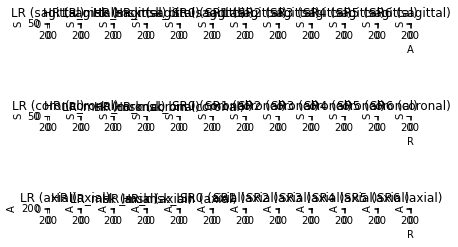

In [18]:
test_subjects_new_sim = []
for subject in tqdm(test_set_sim):
    grid_sampler = tio.inference.GridSampler(
        subject,
        patch_size=(*patch_size,1),
        patch_overlap=overlap,
        padding_mode=0,
    )

    patch_loader = torch.utils.data.DataLoader(
        grid_sampler, batch_size=16)

    for i in range(num_checkpoints):
        if gan[i]:
            model = LitTrainer_gan.load_from_checkpoint(
                netG=generators[i],
                netF=feature_extractor,
                netD=discriminator,
                checkpoint_path=globals()['path' + str(i+1)],
                config=configs[i]
            )
        else:
            model = LitTrainer_org.load_from_checkpoint(
                netG=generators[i],
                netF=feature_extractor,
                checkpoint_path=globals()['path' + str(i+1)],
                config=configs[i]
            )

        model.to(device)
        model.eval()

        aggregator = tio.inference.GridAggregator(grid_sampler)#, overlap_mode='average')

        with torch.no_grad():
            for patches_batch in patch_loader:
                imgs_lr, imgs_hr = patches_batch['LR'][tio.DATA].squeeze(4), patches_batch['HR'][tio.DATA].squeeze(4)
                gen_hr = model(imgs_lr.to(device)).unsqueeze(4)
                locations = patches_batch[tio.LOCATION]
                aggregator.add_batch(gen_hr, locations)

        foreground = aggregator.get_output_tensor()
        generated = tio.ScalarImage(tensor=foreground)
        subject.add_image(generated, 'SR'+str(i))
    test_subjects_new_sim.append(subject)
test_subjects_new_sim[0].plot()

100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [05:40<00:00, 48.69s/it]


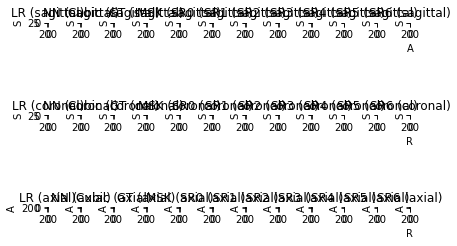

In [19]:
test_subjects_new_real = []
for subject in tqdm(test_set_real):
    grid_sampler = tio.inference.GridSampler(
        subject,
        patch_size=(*patch_size,1),
        patch_overlap=overlap,
        padding_mode=0,
    )

    patch_loader = torch.utils.data.DataLoader(
        grid_sampler, batch_size=16)

    for i in range(num_checkpoints):
        if gan[i]:
            model = LitTrainer_gan.load_from_checkpoint(
                netG=generators[i],
                netF=feature_extractor,
                netD=discriminator,
                checkpoint_path=globals()['path' + str(i+1)],
                config=configs[i]
            )
        else:
            model = LitTrainer_org.load_from_checkpoint(
                netG=generators[i],
                netF=feature_extractor,
                checkpoint_path=globals()['path' + str(i+1)],
                config=configs[i]
            )

        model.to(device)
        model.eval()

        aggregator = tio.inference.GridAggregator(grid_sampler)#, overlap_mode='average')
        with torch.no_grad():
            for patches_batch in patch_loader:
                imgs_lr, imgs_hr = patches_batch['LR'][tio.DATA].squeeze(4), patches_batch['GT'][tio.DATA].squeeze(4)
                gen_hr = model(imgs_lr.to(device)).unsqueeze(4)
                locations = patches_batch[tio.LOCATION]
                aggregator.add_batch(gen_hr, locations)

        foreground = aggregator.get_output_tensor()
        generated = tio.ScalarImage(tensor=foreground)
        subject.add_image(generated, 'SR'+str(i))
    test_subjects_new_real.append(subject)
test_subjects_new_real[0].plot()

In [20]:
def post_proc(img:torch.Tensor, bg_idx:np.ndarray, crop_coords:tuple) -> np.ndarray:
    img[bg_idx] = 0
    min, max = crop_coords
    img = img.squeeze(0)[min[0]:max[0]+1, min[1]:max[1]+1, min[2]:max[2]+1].numpy()*std
    return img

In [21]:
metrics = ['NCC', 'SSIM', 'NRMSE']
scores_real = {key:{'SR'+str(num):[] for num in range(num_checkpoints)} for key in metrics}

calc_interpolations = True
interpolations = ['Cubic']
if calc_interpolations:
    for key in metrics:
        for interp in interpolations:
            scores_real[key][interp] = []

for i in range(len(test_subjects_new_real)):
    mask = test_subjects_new_real[i]['MSK'].data

    bg_idx = np.where(mask==0)
    brain_idx = np.where(mask.squeeze(0)!=0)
    crop_coords = ([brain_idx[i].min() for i in range(len(brain_idx))],
                   [brain_idx[i].max() for i in range(len(brain_idx))])

    HR = post_proc(test_subjects_new_real[i]['GT'].data, bg_idx, crop_coords)
    if calc_interpolations:
        for interp in interpolations:
            img_int = post_proc(test_subjects_new_real[i][interp].data, bg_idx, crop_coords)
            ncc, ssim, nrmse = get_scores(HR, img_int)
            scores_real['NCC'][interp].append(ncc)
            scores_real['SSIM'][interp].append(ssim)
            scores_real['NRMSE'][interp].append(nrmse)

    for j in range(num_checkpoints):
        SR = post_proc(test_subjects_new_real[i]['SR' + str(j)].data, bg_idx, crop_coords)
        ncc, ssim, nrmse = get_scores(HR, SR)

        scores_real['NCC']['SR' + str(j)].append(ncc)
        scores_real['SSIM']['SR' + str(j)].append(ssim)
        scores_real['NRMSE']['SR' + str(j)].append(nrmse)

In [22]:
metrics = ['NCC', 'SSIM', 'NRMSE']
scores_simulated = {key:{'SR'+str(num):[] for num in range(num_checkpoints)} for key in metrics}

for i in range(len(test_subjects_new_sim)):
    mask = test_subjects_new_sim[i]['HR_msk'].data

    bg_idx = np.where(mask==0)
    brain_idx = np.where(mask.squeeze(0)!=0)
    crop_coords = ([brain_idx[i].min() for i in range(len(brain_idx))],
                   [brain_idx[i].max() for i in range(len(brain_idx))])


    HR   = post_proc(test_subjects_new_sim[i]['HR'].data, bg_idx, crop_coords)

    for j in range(num_checkpoints):
        SR = post_proc(test_subjects_new_sim[i]['SR' + str(j)].data, bg_idx, crop_coords)
        ncc, ssim, nrmse = get_scores(HR, SR)

        scores_simulated['NCC']['SR' + str(j)].append(ncc)
        scores_simulated['SSIM']['SR' + str(j)].append(ssim)
        scores_simulated['NRMSE']['SR' + str(j)].append(nrmse)

In [23]:
labels_sim = ['0', '1', '2', '3', '4', '5', '6']
labels_real = labels_sim + ['Cubic']

# path = 'figs/time'
# os.makedirs(path, exist_ok=True)
fig_size = [8,4]
# fname = 'epoch_9_adv'

[Text(1, 0, '0'),
 Text(2, 0, '1'),
 Text(3, 0, '2'),
 Text(4, 0, '3'),
 Text(5, 0, '4'),
 Text(6, 0, '5'),
 Text(7, 0, '6'),
 Text(8, 0, 'Cubic')]

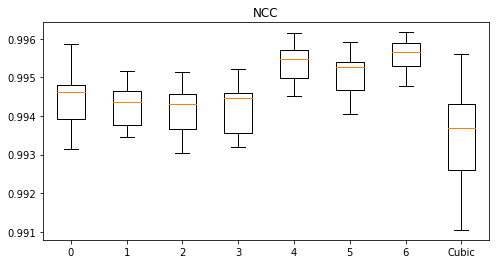

In [24]:
fig, ax = plt.subplots(figsize=fig_size)
fig.set_facecolor('white')
ax.set_title('NCC')
ax.boxplot(scores_real['NCC'].values(), showfliers=False)
ax.set_xticklabels(labels_real)
# fig.savefig(os.path.join(path, fname+'_real_NCC'), dpi=240)

[Text(1, 0, '0'),
 Text(2, 0, '1'),
 Text(3, 0, '2'),
 Text(4, 0, '3'),
 Text(5, 0, '4'),
 Text(6, 0, '5'),
 Text(7, 0, '6'),
 Text(8, 0, 'Cubic')]

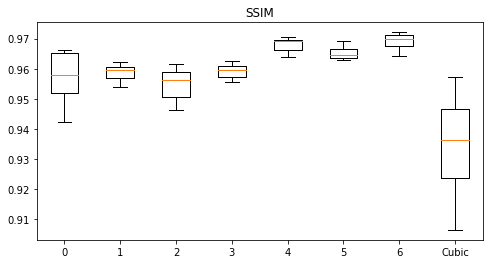

In [25]:
fig, ax = plt.subplots(figsize=fig_size)
fig.set_facecolor('white')
ax.set_title('SSIM')
ax.boxplot(scores_real['SSIM'].values(), showfliers=False)
ax.set_xticklabels(labels_real)
# fig.savefig(os.path.join(path, fname+'_real_SSIM'), dpi=240)

[Text(1, 0, '0'),
 Text(2, 0, '1'),
 Text(3, 0, '2'),
 Text(4, 0, '3'),
 Text(5, 0, '4'),
 Text(6, 0, '5'),
 Text(7, 0, '6'),
 Text(8, 0, 'Cubic')]

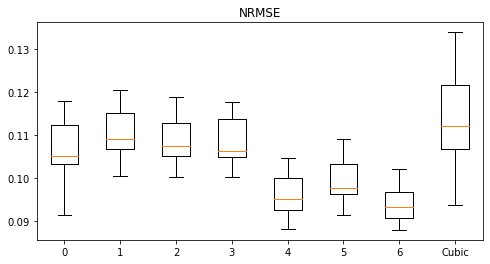

In [26]:
fig, ax = plt.subplots(figsize=fig_size)
fig.set_facecolor('white')
ax.set_title('NRMSE')
ax.boxplot(scores_real['NRMSE'].values(), showfliers=False)
ax.set_xticklabels(labels_real)
# fig.savefig(os.path.join(path, fname+'_real_NRMSE'), dpi=240)

[Text(1, 0, '0'),
 Text(2, 0, '1'),
 Text(3, 0, '2'),
 Text(4, 0, '3'),
 Text(5, 0, '4'),
 Text(6, 0, '5'),
 Text(7, 0, '6')]

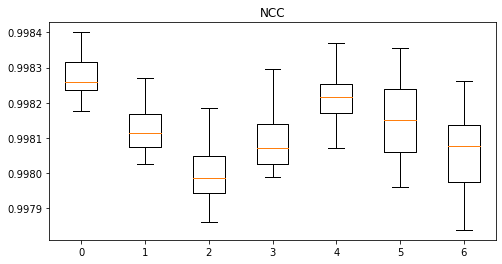

In [27]:
fig, ax = plt.subplots(figsize=fig_size)
fig.set_facecolor('white')
ax.set_title('NCC')
ax.boxplot(scores_simulated['NCC'].values(), showfliers=False)
ax.set_xticklabels(labels_sim)
# fig.savefig(os.path.join(path, fname+'_sim_NCC'), dpi=240)

[Text(1, 0, '0'),
 Text(2, 0, '1'),
 Text(3, 0, '2'),
 Text(4, 0, '3'),
 Text(5, 0, '4'),
 Text(6, 0, '5'),
 Text(7, 0, '6')]

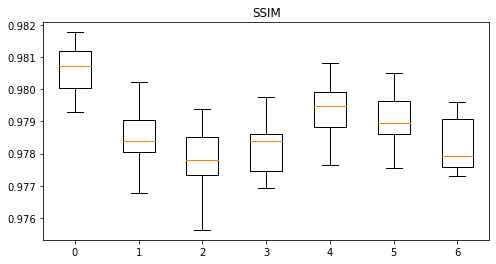

In [28]:
fig, ax = plt.subplots(figsize=fig_size)
fig.set_facecolor('white')
ax.set_title('SSIM')
ax.boxplot(scores_simulated['SSIM'].values(), showfliers=False)
ax.set_xticklabels(labels_sim)
# fig.savefig(os.path.join(path, fname+'_sim_SSIM'), dpi=240)

[Text(1, 0, '0'),
 Text(2, 0, '1'),
 Text(3, 0, '2'),
 Text(4, 0, '3'),
 Text(5, 0, '4'),
 Text(6, 0, '5'),
 Text(7, 0, '6')]

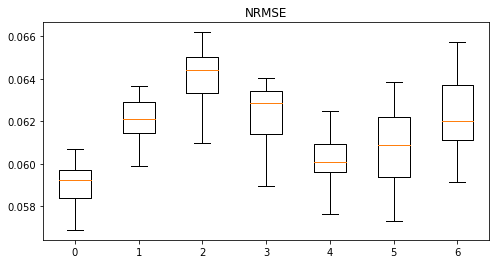

In [29]:
fig, ax = plt.subplots(figsize=fig_size)
fig.set_facecolor('white')
ax.set_title('NRMSE')
ax.boxplot(scores_simulated['NRMSE'].values(), showfliers=False)
ax.set_xticklabels(labels_sim)
# fig.savefig(os.path.join(path, fname+'_sim_NRMSE'), dpi=240)

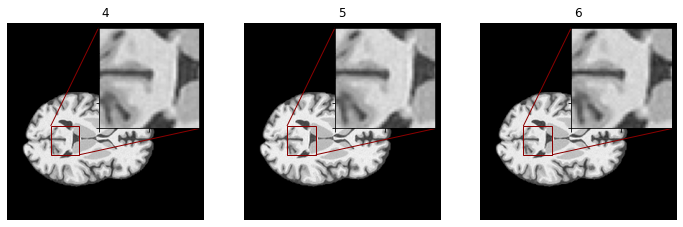

In [30]:
img_slice0 = test_subjects_new_sim[0]['SR4'].data[0,:,:,35].numpy()*std
img_slice1 = test_subjects_new_sim[0]['SR5'].data[0,:,:,35].numpy()*std
img_slice2 = test_subjects_new_sim[0]['SR6'].data[0,:,:,35].numpy()*std

fig, axes = plt.subplots(1,3, figsize=[12,4])
fig.set_facecolor('white')
imgs = [img_slice0, img_slice1, img_slice2]
titles = ['4', '5', '6']
for i, axis in enumerate(axes):
    axis.set_axis_off()
    axis.set_title(titles[i])
    x1, x2, y1, y2 = 60, 100, 90, 130

    axis.imshow(np.pad(imgs[i], (0,50), 'edge'), origin="lower", cmap='gray', vmin=0, vmax=1.1)
    axins = zoomed_inset_axes(axis, 3.5, loc=1) # zoom = 3.5
    axins.imshow(imgs[i],cmap='gray', vmin=0, vmax=1.2)#, interpolation='bicubic')
    axins.set_xlim(x1, x2)
    axins.set_ylim(y1, y2)

    plt.xticks(visible=False)
    plt.yticks(visible=False)
    mark_inset(axis, axins, loc1=2, loc2=4, fc="none", ec='darkred', lw=1)
# plt.draw()
# plt.show()
# fig.savefig('figs/Sim_results_v2.png', dpi=300, bbox_inches='tight')

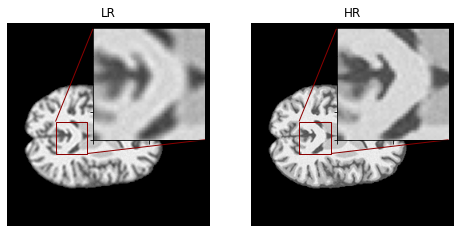

In [15]:
img_slice0 = test_subjects_new_sim[0]['LR'].data[0,:,:,35].numpy()*std
img_slice1 = test_subjects_new_sim[0]['HR'].data[0,:,:,35].numpy()*std

fig, axes = plt.subplots(1,2, figsize=[8,4])
fig.set_facecolor('white')
imgs = [img_slice0, img_slice1]
titles = ['LR', 'HR']
for i, axis in enumerate(axes):
    axis.set_axis_off()
    axis.set_title(titles[i])
    x1, x2, y1, y2 = 60, 100, 90, 130

    axis.imshow(np.pad(imgs[i], (0,30), 'edge'), origin="lower", cmap='gray', vmin=0, vmax=1.1)
    axins = zoomed_inset_axes(axis, 3.5, loc=1) # zoom = 3.5
    axins.imshow(imgs[i], cmap='gray', vmin=0, vmax=1.2)
    axins.set_xlim(x1, x2)
    axins.set_ylim(y1, y2)

    plt.xticks(visible=False)
    plt.yticks(visible=False)
    mark_inset(axis, axins, loc1=2, loc2=4, fc="none", ec='darkred', lw=1)
# fig.savefig('figs/Sim_org_v2', dpi=300, bbox_inches='tight')

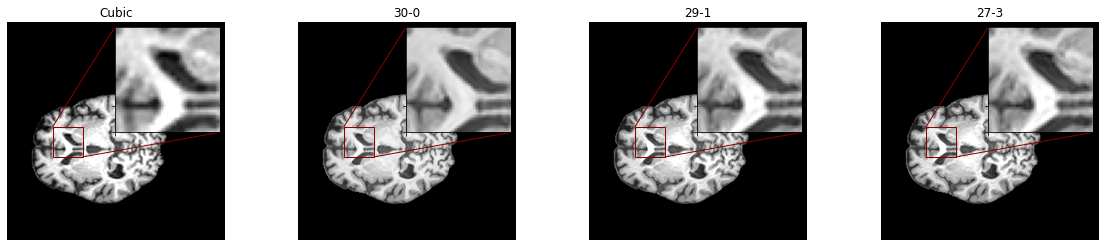

In [45]:
# img_slice0 = test_subjects_new_real[1]['NN'].data[0,:,:,24].numpy()*std
img_slice1 = test_subjects_new_real[1]['Cubic'].data[0,:,:,20].numpy()*std
img_slice2 = test_subjects_new_real[1]['SR0'].data[0,:,:,20].numpy()*std
img_slice3 = test_subjects_new_real[1]['SR1'].data[0,:,:,20].numpy()*std
img_slice4 = test_subjects_new_real[1]['SR1'].data[0,:,:,20].numpy()*std

fig, axes = plt.subplots(1,4, figsize=[20,4])
fig.set_facecolor('white')
imgs = [img_slice1, img_slice2, img_slice3, img_slice4]
titles = ['Cubic', '30-0', '29-1', '27-3']
for i, axis in enumerate(axes):
    axis.set_axis_off()
    axis.set_title(titles[i])
    x1, x2, y1, y2 = 60, 100, 110, 150

    axis.imshow(np.pad(imgs[i], (0,50), 'edge'), origin="lower", cmap='gray', vmin=0, vmax=1.2)
    axins = zoomed_inset_axes(axis, 3.5, loc=1) # zoom = 3.5
    axins.imshow(imgs[i],cmap='gray', vmin=0, vmax=1.3)#, interpolation='bicubic')
    axins.set_xlim(x1, x2)
    axins.set_ylim(y1, y2)

    plt.xticks(visible=False)
    plt.yticks(visible=False)
    mark_inset(axis, axins, loc1=2, loc2=4, fc="none", ec='darkred', lw=1)
# plt.draw()
# plt.show()
fig.savefig('figs/mixed_data.png', dpi=300, bbox_inches='tight')

In [36]:
img_sim = ImagePair(number=100206, select_slices=None, data_resolution='2mm_1mm')
subject = img_sim.subject()
header = img_sim.info()['HR']['header']
max_vals = {
    'LR': img_sim.info()['LR']['scaling'],
    'HR': img_sim.info()['HR']['scaling'],
    'SR': img_sim.info()['LR']['scaling'],
}

In [33]:
img_real = RealImage(number=7, select_slices=None)
subject = img_real.subject()
header = img_real.info()['GT']['header']
max_vals = {
    'LR': img_real.info()['LR']['scaling'],
    'GT': img_real.info()['GT']['scaling'],
    'NN': img_real.info()['GT']['scaling'],
    'Cu': img_real.info()['GT']['scaling'],
    'MS': img_real.info()['GT']['scaling'],
    'SR': img_real.info()['LR']['scaling'],
}

In [34]:
# test_subjects_new_real[0].plot()
save_subject_all(subject = test_subjects_new_real[0],
                 header = header,
                 pref = 'real',
                 std = std,
                 max_vals = max_vals,
                 source = 'real',
                 path = 'output/mixed_data/sweep')

LR
NN
Cubic
GT
MSK
SR0
SR1
SR2
SR3
SR4
SR5
SR6
